In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import shapely.wkt
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from shapely.geometry import Polygon
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

XLongitude  YLatitude ShapeID   FIPS                    NAME  Area_sqmi  \
0 -176.560565  51.996732   15630  02016         Adak Island, AK   0.196221   
1 -152.112205  58.148559   15631  02150         Afognak Bay, AK   0.196221   
2 -165.913068  54.211260   15632  02013       Akutan Island, AK   0.196221   
3  -97.137111  27.901262   10382  48409        Aransas Pass, TX   0.196221   
4  -88.988335  30.412697   10383  28047  Back Bay of Biloxi, MS   0.196221   

  PortID   ShapeType    ACTIVITYKW  TYPE  \
0   None  Land-based  1.051860e+06  Land   
1   None  Land-based  7.016603e+05  Land   
2   None  Land-based  1.979962e+08  Land   
3   None  Land-based  5.742776e+05  Land   
4   None  Land-based  1.320707e+04  Land   

                                            geometry STATE  
0  POLYGON ((-176.56532 51.99902, -176.56506 51.9...    AK  
1  POLYGON ((-152.11621 58.15151, -152.11585 58.1...    AK  
2  POLYGON ((-165.91752 54.21386, -165.91722 54.2...    AK  
3  POLYGON ((-97.13717 27.90489, -97.13690 27.904...    TX  
4  POLYGON ((-88.98800 30.41631, -88.98772 30.416...    MS

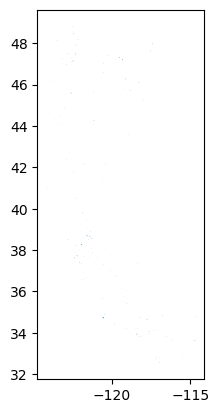

In [2]:
# load port location data
port_loc_dir = 'RawData/Port/Location/Ports_2014NEI.shp'
airport_loc_dir = 'RawData/Port/Location/airport_area.shp'
port_list_dir = 'RawData/Port/port_code_cbp.csv'
border_entry_dir = 'RawData/Port/Location/border_entry.txt'
# filter by location
selected_states = ['California', 'Washington', 'Oregon']
selected_fips = ['CA', 'WA', 'OR']

#sea and land
port_location = gpd.read_file(port_loc_dir)
port_location.loc[port_location['NAME'] == 'Carquinez', 'TYPE'] = 'Land'
port_location.loc[port_location['NAME'] == 'Richmond, CA', 'TYPE'] = 'Land'
port_location = \
port_location.loc[port_location['TYPE'] == 'Land']
port_location.loc[:, 'STATE'] = \
port_location.loc[:, 'NAME'].str.split(', ').str[1]
# port_location = \
# port_location.loc[port_location['STATE'].isin(selected_fips)]
port_location = port_location.to_crs('4326')

airport_location = gpd.read_file(airport_loc_dir)
airport_location = \
airport_location.loc[airport_location['STATE'].isin(selected_states)]
airport_location = airport_location.to_crs('4326')
airport_location.plot()

f = open(border_entry_dir,'r')
border_entry = f.readlines()
f.close()
list_of_ports = read_csv(port_list_dir)
port_location.head(5)

In [3]:
# separate list of ports by airport and sea/land ports
list_of_ports.loc[:, 'NAME'] = \
list_of_ports.loc[:, 'CBP Port Location'].str.split('(').str[0]

list_of_ports.loc[:, 'STATE'] = list_of_ports.loc[:, 'NAME'].str.split(',').str[1]
list_of_ports.loc[:, 'STATE'] = list_of_ports.loc[:, 'STATE'].str.replace(" ", "")
list_of_ports = list_of_ports.loc[list_of_ports['STATE'].isin(selected_fips)]

print(len(list_of_ports))

list_of_airports = \
list_of_ports.loc[list_of_ports['is_airport'] == 1]
print('numbers of airports in selected region:')
print(len(list_of_airports))
print(list_of_airports.NAME.unique())

list_of_other_ports = \
list_of_ports.loc[list_of_ports['is_airport'] == 0]
print('numbers of other ports in selected region:')
print(len(list_of_other_ports))

list_of_ports.head(5)

48
numbers of airports in selected region:
9
['San Francisco International Airport, CA ' 'Fresno, CA '
 'San Jose International Airport, CA '
 'Sacramento International Airport, CA '
 'Portland International Airport, OR ' 'Friday Harbor, WA ' 'Spokane, WA '
 'Seattle-Tacoma International Airport, WA ' 'Grant County Airport, WA ']
numbers of other ports in selected region:
39


Export Port Code                               CBP Port Location  \
0              2801  San Francisco International Airport, CA (Port)   
1              2802                               Eureka, CA (Port)   
2              2803                               Fresno, CA (Port)   
3              2805                             Monterey, CA (Port)   
4              2809                        San Francisco, CA (Port)   

   is_airport Vessel Air Rail Road Fixed  \
0           1      N   Y    N    N     N   
1           0      Y   N    N    N     N   
2           1      Y   Y    N    N     N   
3           0      Y   N    N    N     N   
4           0      Y   N    N    N     N   

                                       NAME STATE  
0  San Francisco International Airport, CA     CA  
1                               Eureka, CA     CA  
2                               Fresno, CA     CA  
3                             Monterey, CA     CA  
4                        San Francisco, CA     CA

San Francisco International Airport, CA 
san francisco intl 86
Fresno, CA 
fresno air terminal 86
San Jose International Airport, CA 
san jose international 90
Sacramento International Airport, CA 
sacramento metropolitan 86
Portland International Airport, OR 
find the match!
portland intl 86
Friday Harbor, WA 
friday harbor 95
Spokane, WA 
spokane intl 78
Seattle-Tacoma International Airport, WA 
seattle-tacoma intl 86
Grant County Airport, WA 
grant county 90


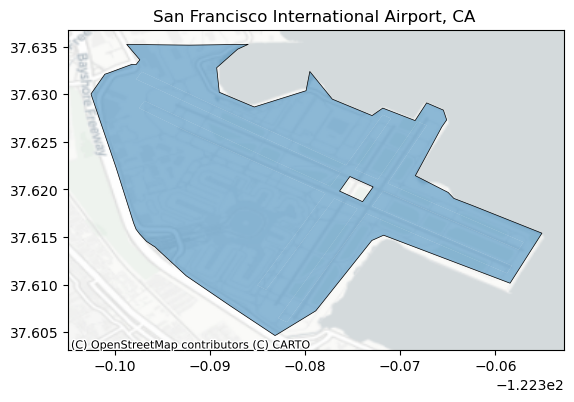

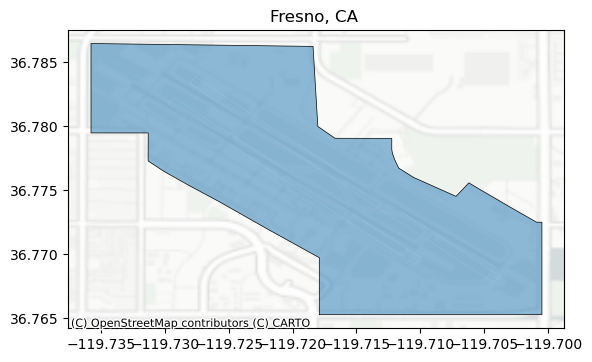

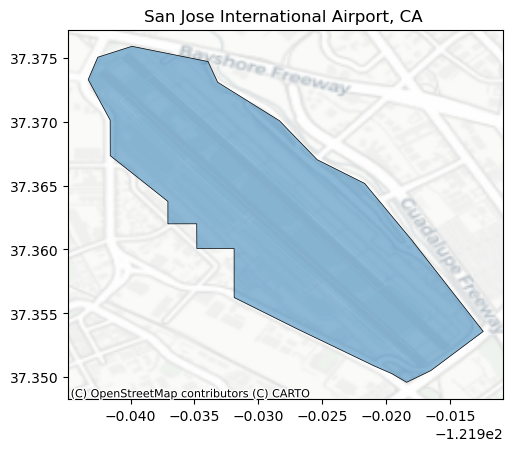

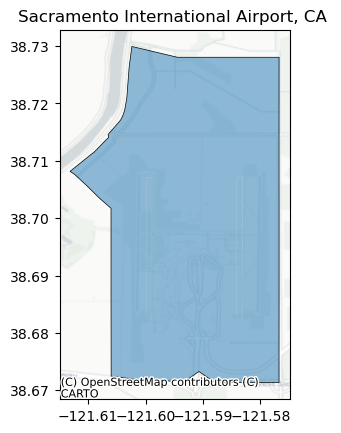

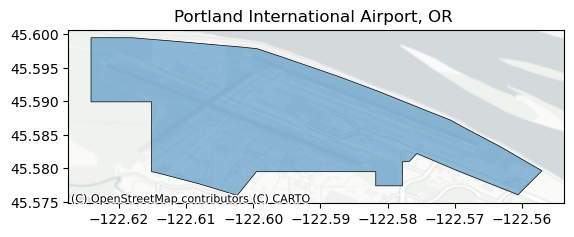

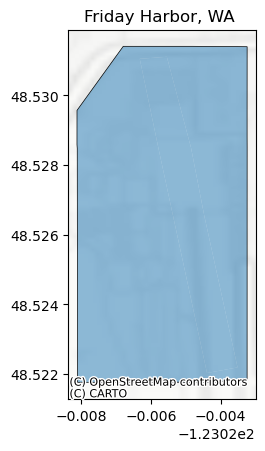

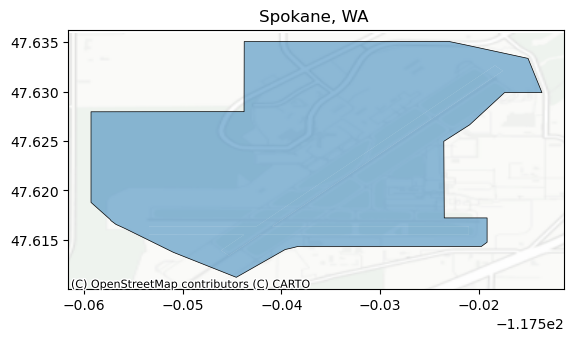

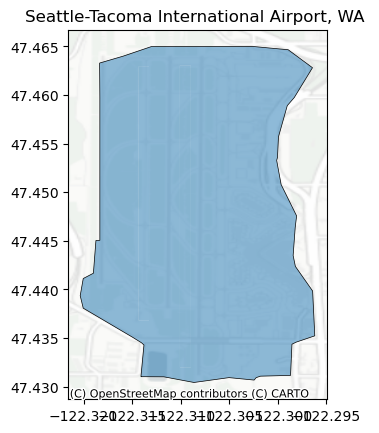

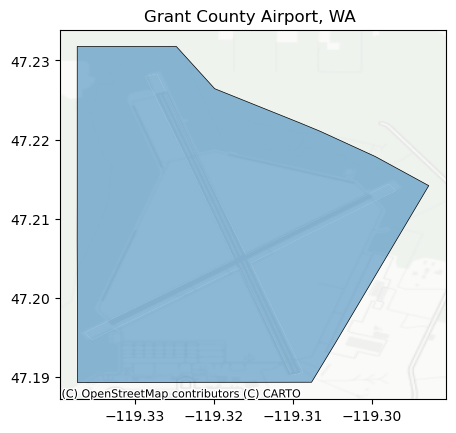

In [4]:
# match airport
# import difflib
list_of_airports.head(5)
airport_names = list_of_airports.NAME.unique()
# airport_names = lower(airport_names)
output_airport_gdf = None
matched_port = []
airport_location['NAME'] = airport_location['NAME'].str.lower()
for airport in airport_names:
    print(airport)
    airport_loc = \
    process.extract(airport, airport_location['NAME'], limit=1)[0][0]
    airport_score = \
    process.extract(airport, airport_location['NAME'], limit=1)[0][1]

    # manually match some:
    if airport == 'Portland International Airport, OR ':
        print('find the match!')
        airport_loc = 'portland intl'
    print(airport_loc, airport_score)
    airport_location_sel = \
    airport_location.loc[airport_location['NAME'] == airport_loc]
    airport_location_dissolved = airport_location_sel.dissolve()
    # airport_location_to_plot = airport_location_sel.buffer(0.5)
    ax = airport_location_sel.plot(alpha = 0.5)
    airport_location_dissolved.plot(ax = ax, facecolor='none', 
                              edgecolor='k',linewidth = 0.5)
    cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron, zoom = 13)
    plt.title(airport)
    plt.savefig('RawData/Port/Plot/' + airport_loc + '_loc.png')
    airport_location_dissolved.loc[:, 'PORTID'] = airport
    airport_location_dissolved = \
    airport_location_dissolved[['NAME', 'STATE', 'geometry', 'PORTID']]
    output_airport_gdf = \
    pd.concat([output_airport_gdf, airport_location_dissolved])
    matched_port.append(airport)
    # break
# airport_location_dissolved

In [15]:
output_airport_gdf.head(5)

NAME       STATE  \
0       san francisco intl  California   
0      fresno air terminal  California   
0   san jose international  California   
0  sacramento metropolitan  California   
0            portland intl      Oregon   

                                            geometry  \
0  POLYGON ((-122.38791 37.60778, -122.39251 37.6...   
0  POLYGON ((-119.71791 36.76525, -119.71791 36.7...   
0  POLYGON ((-121.92090 37.35086, -121.92697 37.3...   
0  POLYGON ((-121.59067 38.67326, -121.59106 38.6...   
0  POLYGON ((-122.60812 45.57772, -122.61452 45.5...   

                                     PORTID  
0  San Francisco International Airport, CA   
0                               Fresno, CA   
0       San Jose International Airport, CA   
0     Sacramento International Airport, CA   
0       Portland International Airport, OR

Eureka, CA 
eureka 90
Monterey, CA 
monterey 90
San Francisco, CA 
san francisco 95
Stockton, CA 
stockton 90
Oakland, CA 
oakland 90
Richmond, CA 
richmond, ca 100
Martinez, CA 
martinez, ca 100
Redwood City, CA 
redwood city, ca 100
Selby, CA 
san pablo bay, ca 86
San Joaquin River, CA 
stockton 86
San Pablo Bay, CA 
san pablo bay, ca 100
Carquinez Strait, CA 
carquinez 90
Astoria, OR 
astoria 90
Newport, OR 
newport 90
Coos Bay, OR 
coos bay 90
Portland, OR 
portland, or 100
Longview, WA 
longview, wa 100
Vancouver, WA 
vancouver 95
Kalama, WA 
kalama 90
Seattle, WA 
seattle 90
Tacoma, WA 
tacoma 90
Aberdeen-Hoquiam, WA 
grays harbor 86
Blaine, WA 
blaine, wa 100
Bellingham, WA 
bellingham, wa 100
Everett, WA 
everett 90
Port Angeles, WA 
port angeles 95
Port Townsend, WA 
port townsend, wa 100
Sumas, WA 
do not process Sumas, WA 
Anacortes, WA 
anacortes 95
Danville, WA 
do not process Danville, WA 
Ferry, WA 
do not process Ferry, WA 
Boundary, WA 
do not process Boundary, WA 
Lau

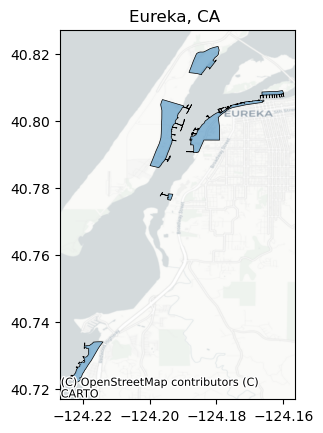

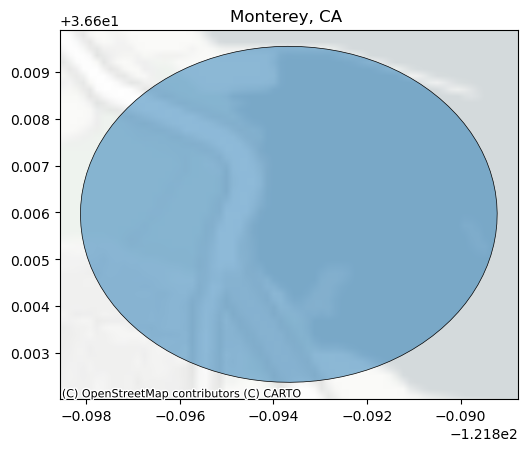

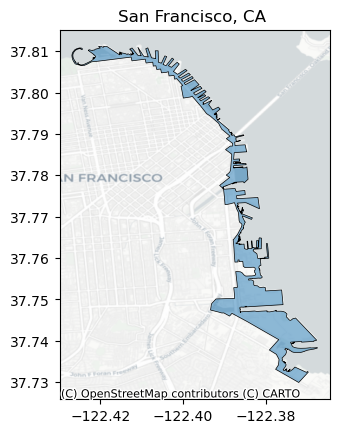

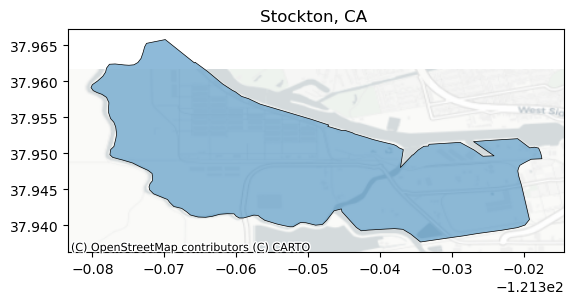

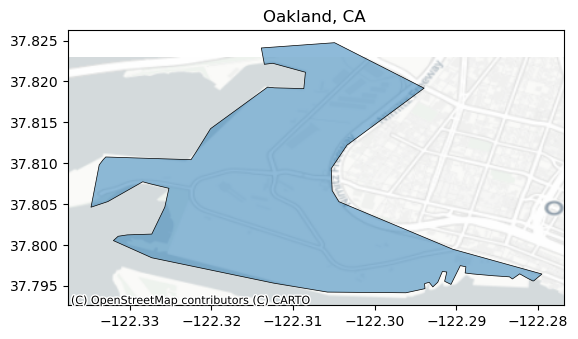

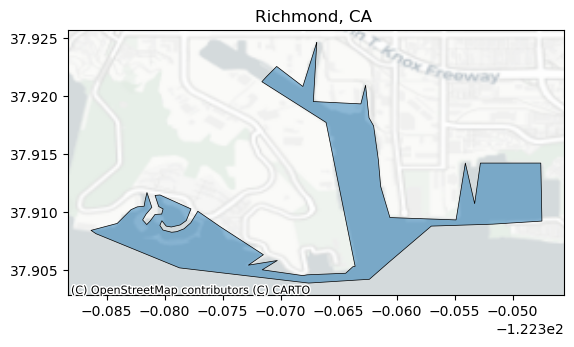

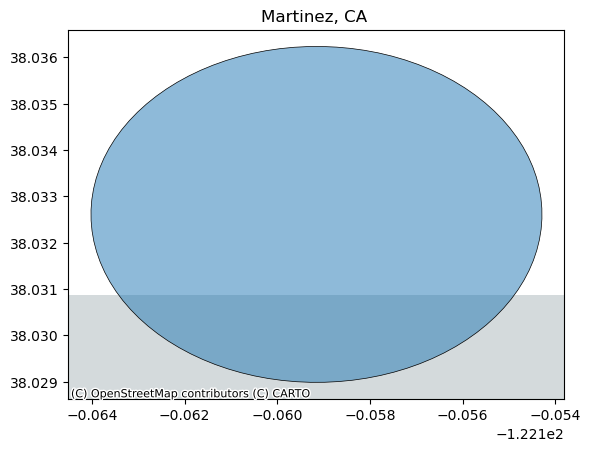

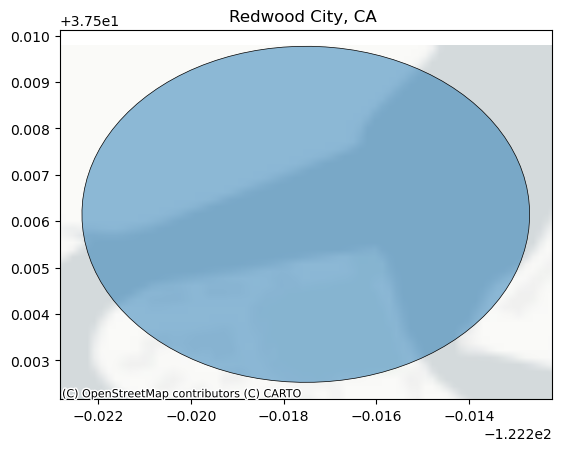

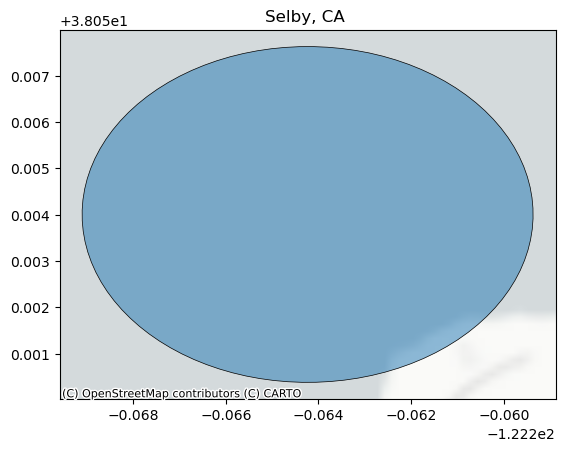

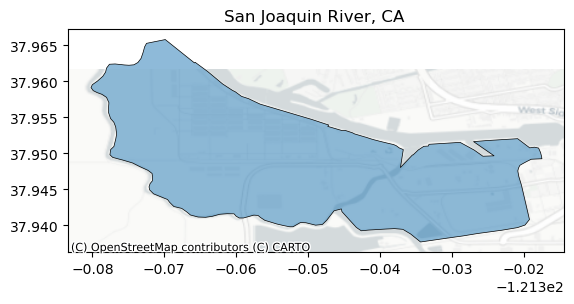

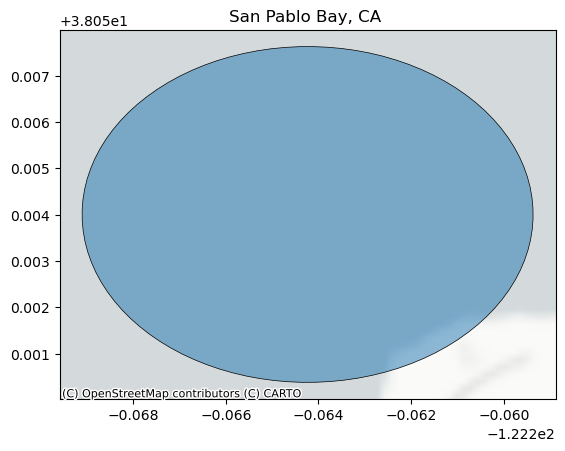

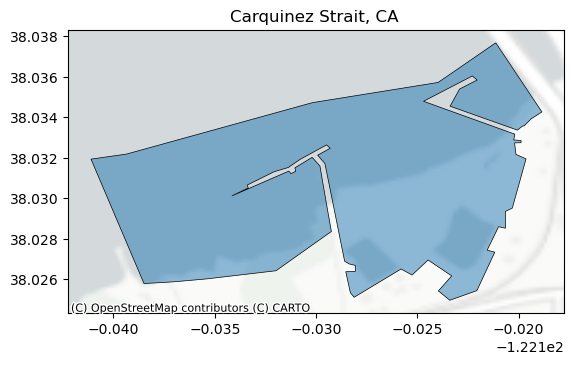

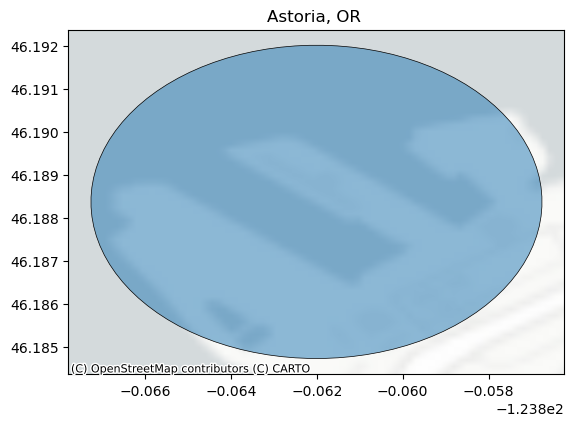

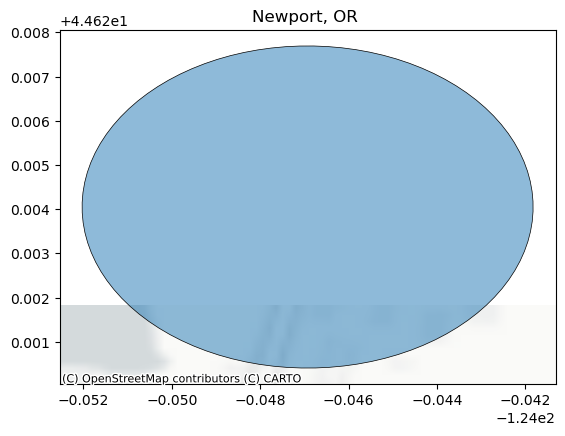

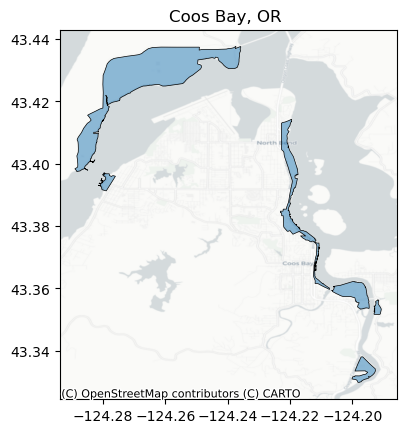

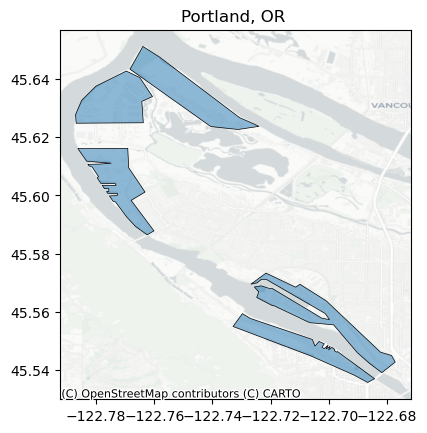

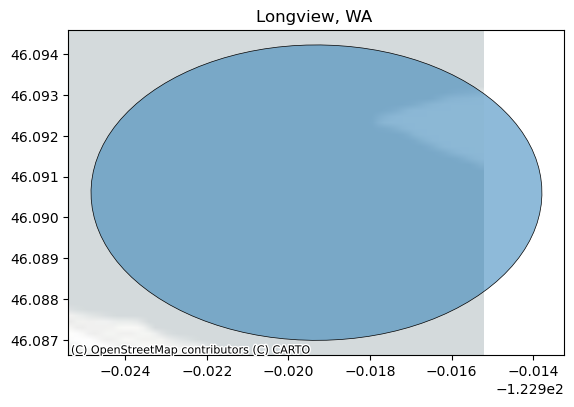

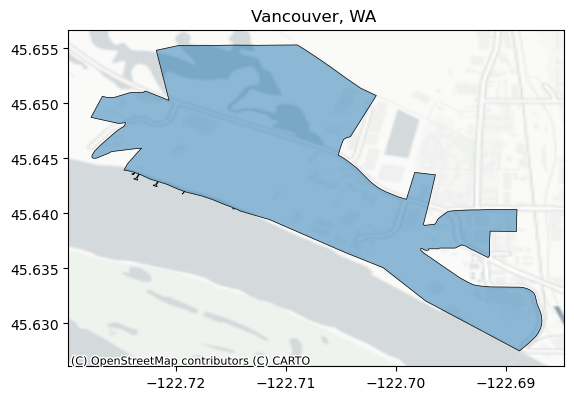

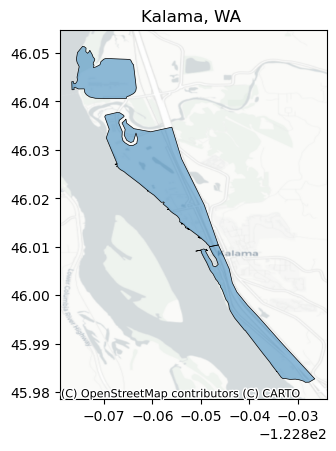

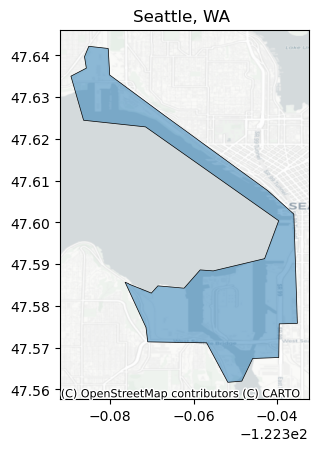

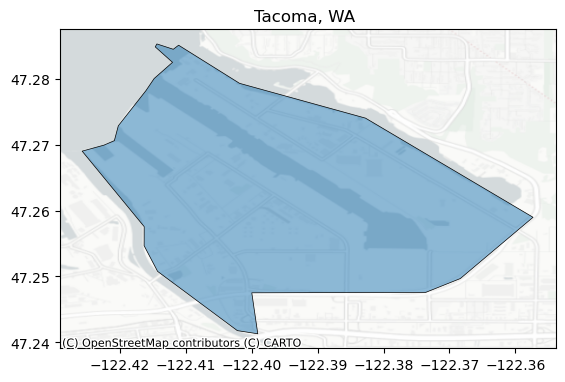

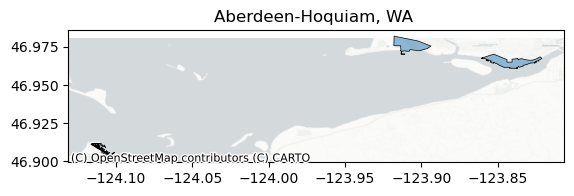

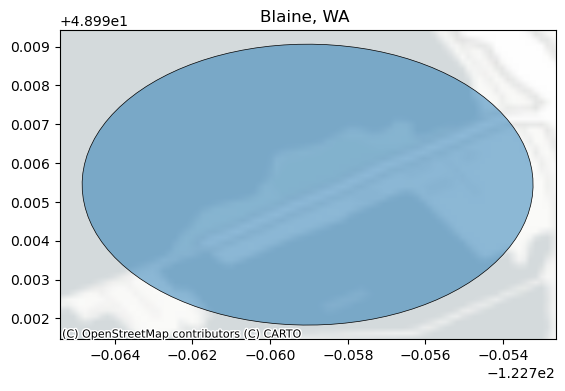

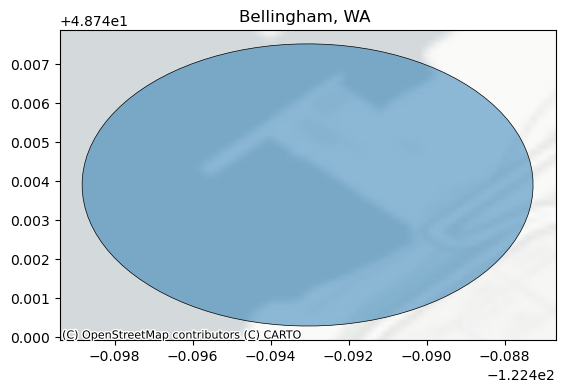

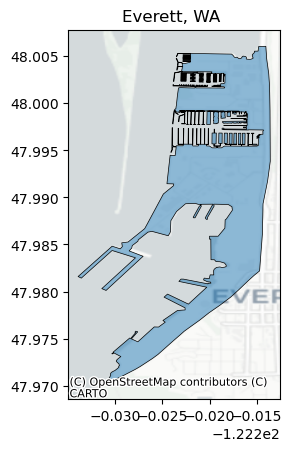

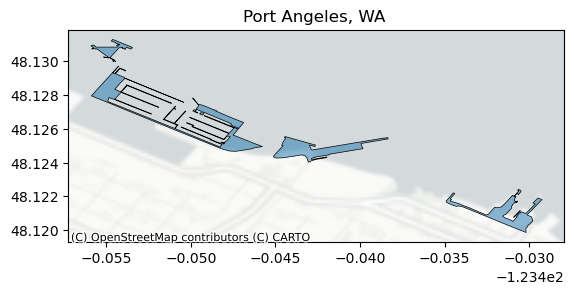

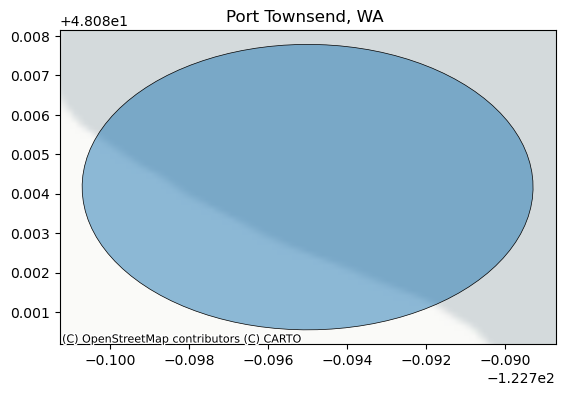

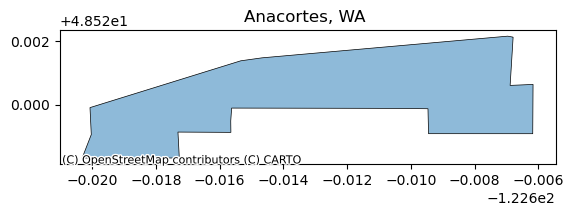

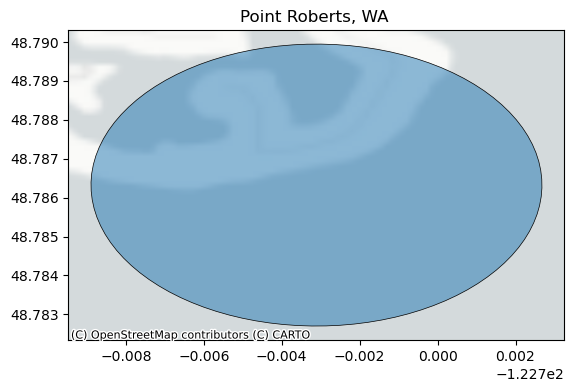

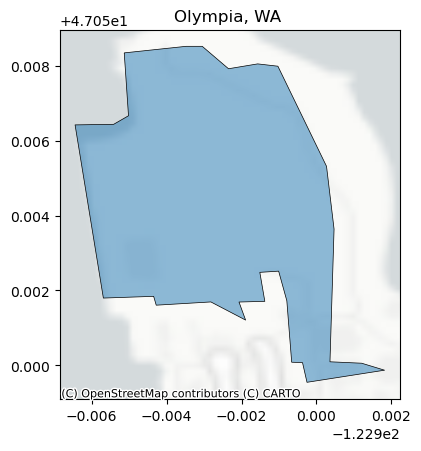

In [5]:
# match other ports
# import difflib

otherport_names = list_of_other_ports.NAME.unique()
# airport_names = lower(airport_names)
output_port_gdf = None
# matched_port = []

port_location['NAME'] = port_location['NAME'].str.lower()
port_location = \
port_location.loc[port_location['NAME'] != 'other ports l.a. district, ca']
port_location = \
port_location.loc[port_location['FIPS'] != '44005']
canadian_border = ['Sumas, WA ', 
                   'Danville, WA ', 
                   'Ferry, WA ',
                'Boundary, WA ', 
                   'Laurier, WA ', 
                   'Oroville, WA ',
                'Frontier, WA ', 
                   'Lynden, WA ', 
                   'Metaline Falls, WA '] # 9 port
for port in otherport_names:
    print(port)
    port_loc = \
    process.extract(port, port_location['NAME'], limit=1)[0][0]
    port_score = \
    process.extract(port, port_location['NAME'], limit=1)[0][1]

    # manually match some:
    if port == 'Monterey, CA ':
        # print('find the match!')
        port_loc = 'monterey'
    if port == 'Richmond, CA ':
        # print('find the match!')
        port_loc = 'richmond, ca'
    if port == 'Selby, CA ':
        port_loc = 'san pablo bay, ca'
    if port == 'San Joaquin River, CA ':
        port_loc = 'stockton'
    if port == 'Carquinez Strait, CA ':
        port_loc = 'carquinez'
    if port == 'Aberdeen-Hoquiam, WA ':
        port_loc = 'grays harbor'
    if port in canadian_border:
        print('do not process '  + port)
        continue
    print(port_loc, port_score)
    port_location_sel = \
    port_location.loc[port_location['NAME'] == port_loc]
    port_location_dissolved = port_location_sel.dissolve()
    # airport_location_to_plot = airport_location_sel.buffer(0.5)
    ax = port_location_sel.plot(alpha = 0.5)
    port_location_dissolved.plot(ax = ax, facecolor='none', 
                              edgecolor='k',linewidth = 0.5)
    cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron, zoom = 13)
    plt.title(port)
    plt.savefig('RawData/Port/Plot/' + port_loc + '_loc.png')
    port_location_dissolved.loc[:, 'PORTID'] = port
    port_location_dissolved = \
    port_location_dissolved[['NAME', 'STATE', 'geometry', 'PORTID']]
    output_port_gdf = \
    pd.concat([output_port_gdf, port_location_dissolved])
    matched_port.append(port)
output_port_gdf.loc[:, 'TYPE'] = 'Port'

In [6]:
# find US Canada border in WA
lwas=[]
start=False
for l in border_entry:
    if "Washington" in l:
        start=True
    if "Idaho" in l:
        break
    if start==True:
        lwas.append(l)
    
pos=[] # position file of WA borders
for l in lwas:
    if "″N" in l:
        ls=l.split('\t')
        p=ls[-1].split()
        # print(ls)
        pos.append([ls[0]]+p)
        # print("#####",pos[-1])

In [7]:
# format border crossing
def parse(w):
    w=re.split('°|′|″', w)[:3]
    w=[float(i) for i in w]
    w=w[0]+w[1]/60.+w[2]/60/60
    return w

p2=[]
for p in pos:
    q=np.array([-parse(p[2][:-1]), parse(p[1][:-1])])
    q1=[q+np.array(i)*1e-2 for i in [(-1,0),(0,-1),(1,0),(0,1)]]
    p1 = Polygon(q1)
    p2.append(p1)
    # print(p[0], p1)

<Axes: >

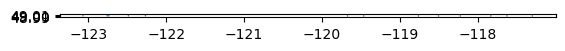

In [8]:
# create geodataframe for border crossing
d = {'NAME': [p[0] for p in pos]} # NAME
g = gpd.GeoSeries(p2) # GEOMETRY
df = pd.DataFrame(d)
border_cross_gdf=gpd.GeoDataFrame(df, geometry=g, crs= 'EPSG:4326')
border_cross_gdf.plot()

Sumas, WA 
Sumas 90
Danville, WA 
Danville 90
Ferry, WA 
Ferry 90
Boundary, WA 
Boundary 90
Laurier, WA 
Laurier 90
Oroville, WA 
Oroville 90
Frontier, WA 
Frontier 90
Lynden, WA 
Lynden 90
Metaline Falls, WA 
Metaline Falls 95


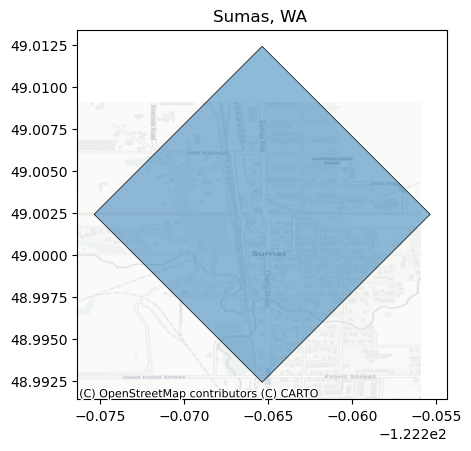

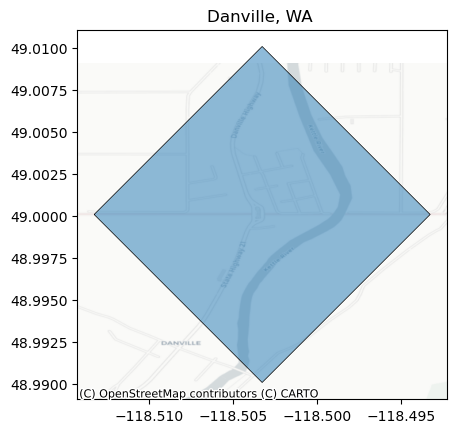

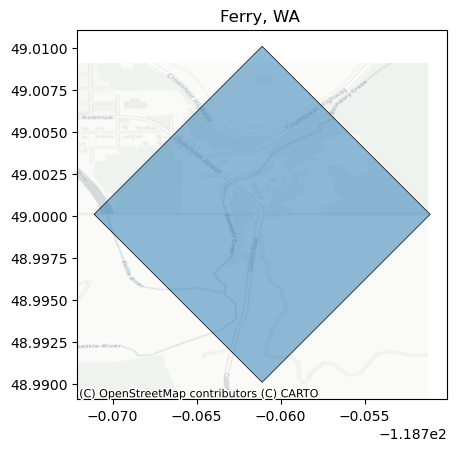

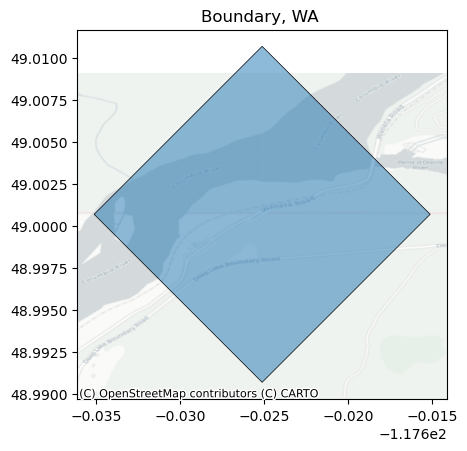

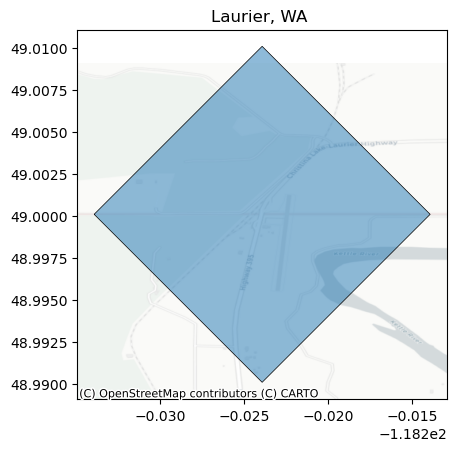

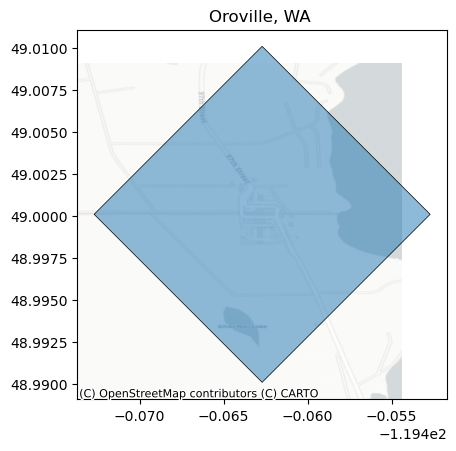

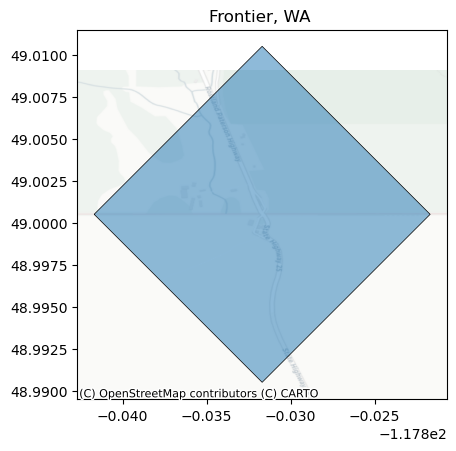

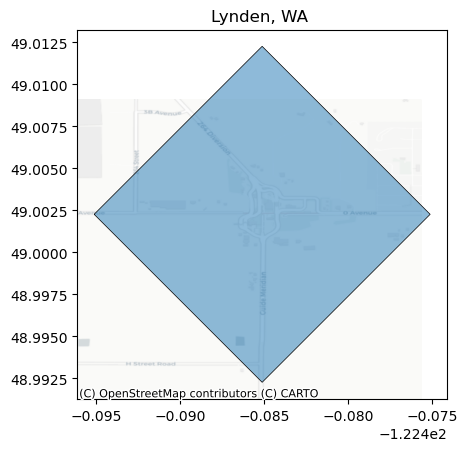

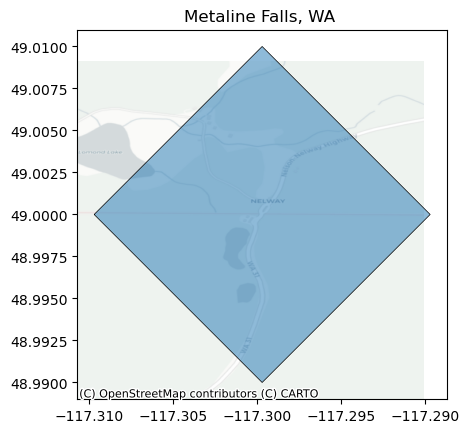

In [9]:
# canadian_border = ['Sumas, WA ', # yes
#                    'Danville, WA ', # yes
#                    'Ferry, WA ', # yes
#                 'Boundary, WA ', # yes
#                    'Laurier, WA ', # yes
#                    'Oroville, WA ', # yes
#                 'Frontier, WA ', #yes
#                    'Lynden, WA ', # yes
#                    'Metaline Falls, WA '] # yes
# format output
# border_cross_gdf = border_cross_gdf.to_crs('EPSG:4236')
for port in canadian_border:
    print(port)
    port_loc = \
    process.extract(port, border_cross_gdf['NAME'], limit=1)[0][0]
    port_score = \
    process.extract(port, border_cross_gdf['NAME'], limit=1)[0][1]

    print(port_loc, port_score)
    border_cross_sel = \
    border_cross_gdf.loc[border_cross_gdf['NAME'] == port_loc]
    border_cross_sel_dissolved = border_cross_sel.dissolve()
    # airport_location_to_plot = airport_location_sel.buffer(0.5)
    ax = border_cross_sel.plot(alpha = 0.5)
    border_cross_sel_dissolved.plot(ax = ax, facecolor='none', 
                              edgecolor='k',linewidth = 0.5)
    cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron)
    plt.title(port)
    plt.savefig('RawData/Port/Plot/' + port_loc + '_loc.png')
    border_cross_sel_dissolved.loc[:, 'PORTID'] = port
    border_cross_sel_dissolved.loc[:, 'STATE'] = 'WA'
    border_cross_sel_dissolved = \
    border_cross_sel_dissolved[['NAME', 'STATE', 'geometry', 'PORTID']]
    border_cross_sel_dissolved.loc[:, 'TYPE'] = 'Crossing'
    output_port_gdf = \
    pd.concat([output_port_gdf, border_cross_sel_dissolved])
    matched_port.append(port)

In [10]:
output_airport_gdf.loc[:, 'TYPE'] = 'Airport'

combined_port_gdf = pd.concat([output_airport_gdf, output_port_gdf])
print(len(combined_port_gdf))
combined_port_gdf.loc[:, 'PORTID'] = combined_port_gdf.loc[:, 'PORTID'].str[:-1]
print(combined_port_gdf.PORTID.unique()[0:5])
combined_port_gdf.head(5)

48
['San Francisco International Airport, CA' 'Fresno, CA'
 'San Jose International Airport, CA'
 'Sacramento International Airport, CA'
 'Portland International Airport, OR']


NAME       STATE  \
0       san francisco intl  California   
0      fresno air terminal  California   
0   san jose international  California   
0  sacramento metropolitan  California   
0            portland intl      Oregon   

                                            geometry  \
0  POLYGON ((-122.38791 37.60778, -122.39251 37.6...   
0  POLYGON ((-119.71791 36.76525, -119.71791 36.7...   
0  POLYGON ((-121.92090 37.35086, -121.92697 37.3...   
0  POLYGON ((-121.59067 38.67326, -121.59106 38.6...   
0  POLYGON ((-122.60812 45.57772, -122.61452 45.5...   

                                    PORTID     TYPE  
0  San Francisco International Airport, CA  Airport  
0                               Fresno, CA  Airport  
0       San Jose International Airport, CA  Airport  
0     Sacramento International Airport, CA  Airport  
0       Portland International Airport, OR  Airport

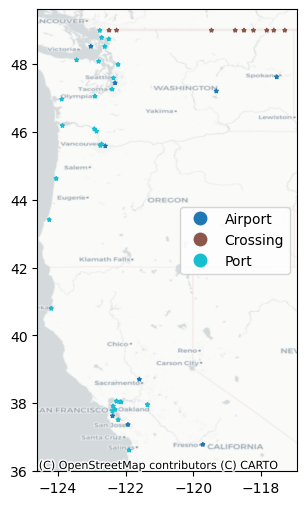

In [11]:
# plot port location

combined_port_df = combined_port_gdf.drop(columns = 'geometry')
combined_port_centroid = combined_port_gdf["geometry"].centroid
combined_port_centroid = \
gpd.GeoDataFrame(geometry = gpd.GeoSeries(combined_port_centroid))
combined_port_centroid = pd.concat([combined_port_centroid, 
                               combined_port_df], axis = 1)

ax = combined_port_centroid.plot(figsize = (4,6), column='TYPE',
                                 marker='*', markersize=8, legend = True)
cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron)
plt.savefig('RawData/Port/Plot/all_ports_location.png')
plt.show()
# combined_port_gdf

16


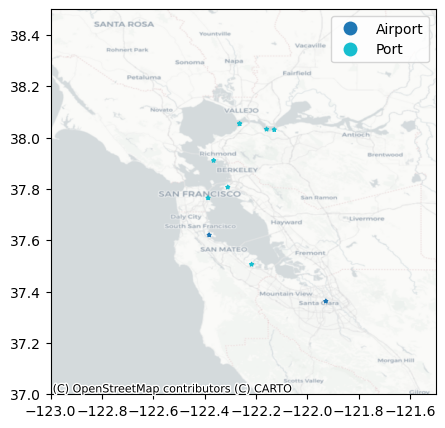

In [40]:
combined_port_centroid.loc[:, 'state_abbr'] = \
combined_port_centroid.loc[:, 'PORTID'].str.split(', ').str[1]
combined_port_centroid_ca = \
combined_port_centroid.loc[combined_port_centroid['state_abbr'] == 'CA']
print(len(combined_port_centroid_ca))
ax = combined_port_centroid_ca.plot(figsize = (5,5), column='TYPE',
                                 marker='*', markersize=8, legend = True)
ax.set_xlim(-123,-121.5)
ax.set_ylim(37,38.5)
cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron)
# for idx, row in combined_port_centroid_ca.iterrows():
#     centroid = row.geometry
#     ax.annotate(text=row['PORTID'], xy=(centroid.x, centroid.y), 
#                  ha='left', fontsize=4)
plt.savefig('RawData/Port/Plot/CA_ports_location.png')
plt.show()

In [21]:
combined_port_centroid_ca

geometry                     NAME       STATE  \
0  POINT (-122.38266 37.62047)       san francisco intl  California   
0  POINT (-119.71807 36.77570)      fresno air terminal  California   
0  POINT (-121.92835 37.36269)   san jose international  California   
0  POINT (-121.59156 38.69981)  sacramento metropolitan  California   
0  POINT (-124.19143 40.79161)                   eureka        None   
0  POINT (-121.89367 36.60596)                 monterey        None   
0  POINT (-122.38687 37.76495)            san francisco        None   
0  POINT (-121.35135 37.94914)                 stockton        None   
0  POINT (-122.31034 37.80686)                  oakland        None   
0  POINT (-122.36547 37.91077)             richmond, ca          CA   
0  POINT (-122.15916 38.03261)             martinez, ca          CA   
0  POINT (-122.21752 37.50615)         redwood city, ca          CA   
0  POINT (-122.26423 38.05400)        san pablo bay, ca          CA   
0  POINT (-121.35135 37.94914)                 stockton        None   
0  POINT (-122.26423 38.05400)        san pablo bay, ca          CA   
0  POINT (-122.12913 38.03064)                carquinez        None   

                                    PORTID     TYPE state_abbr  
0  San Francisco International Airport, CA  Airport         CA  
0                               Fresno, CA  Airport         CA  
0       San Jose International Airport, CA  Airport         CA  
0     Sacramento International Airport, CA  Airport         CA  
0                               Eureka, CA     Port         CA  
0                             Monterey, CA     Port         CA  
0                        San Francisco, CA     Port         CA  
0                             Stockton, CA     Port         CA  
0                              Oakland, CA     Port         CA  
0                             Richmond, CA     Port         CA  
0                             Martinez, CA     Port         CA  
0                         Redwood City, CA     Port         CA  
0                                Selby, CA     Port         CA  
0                    San Joaquin River, CA     Port         CA  
0                        San Pablo Bay, CA     Port         CA  
0                     Carquinez Strait, CA     Port         CA

In [15]:
# write output
out_path = 'SynthFirm_parameters/port_location_CA_WA_OR.geojson'
combined_port_gdf.to_file(out_path, driver="GeoJSON")  

In [41]:
out_path = 'SynthFirm_parameters/port_centroid_CA_only.geojson'
combined_port_centroid_ca.to_file(out_path, driver="GeoJSON")  